In [1]:
import torch
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [2]:
# load Segformer
MODEL_ID = "nvidia/segformer-b0-finetuned-cityscapes-1024-1024"
processor = AutoImageProcessor.from_pretrained(MODEL_ID)
model = SegformerForSemanticSegmentation.from_pretrained(MODEL_ID).to(device).eval()

The image processor of type `SegformerImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

In [ ]:
def segment_support_mask(
    img_path: str,
    processor,
    model,
    device: str = None,
    road_id: int = 0,
    alpha: float = 0.7,
):
    """
    Segment road pixels using a pre-loaded SegFormer Cityscapes model.

    Args:
        img_path: path to image file
        processor: AutoImageProcessor (already loaded)
        model: SegformerForSemanticSegmentation (already loaded)
        device: "cuda" or "cpu". If None, auto-detect.
        road_id: Cityscapes class id for 'road' (often 0). Adjust if needed.
        alpha: overlay strength in [0,1], larger means stronger red overlay.

    Returns:
        road_mask_255: uint8 (H,W), values in {0,255}
        overlay_bgr: uint8 (H,W,3) BGR image with red overlay on road
        info: dict with (W,H) and some internals
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # 1) read image
    img_pil = Image.open(img_path).convert("RGB")
    W, H = img_pil.size

    # 2) forward
    inputs = processor(images=img_pil, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model = model.to(device).eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # 3) resize logits back to original resolution
    logits = outputs.logits  # (1, C, h', w')
    logits = torch.nn.functional.interpolate(
        logits, size=(H, W), mode="bilinear", align_corners=False
    )

    # 4) label map
    pred = logits.argmax(dim=1)[0].detach().cpu().numpy().astype(np.uint8)  # (H,W)

    # 5) support mask (0/255)
    road_mask_255     = ((pred == 0).astype(np.uint8) * 255)
    sidewalk_mask_255 = ((pred == 1).astype(np.uint8) * 255)
    terrain_mask_255  = ((pred == 9).astype(np.uint8) * 255)
    support_mask_255 = np.maximum.reduce([road_mask_255, sidewalk_mask_255, terrain_mask_255])

    # 6) overlay (BGR) with red on support pixels
    img_bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    overlay_bgr = img_bgr.copy()

    # BGR colors: sidewalk=Green, road=Red, terrain=Blue
    COLORS = {
        "sidewalk": np.array([0, 255, 0], dtype=np.uint8),
        "road":     np.array([0, 0, 255], dtype=np.uint8),
        "terrain":  np.array([255, 0, 0], dtype=np.uint8),
    }

    def blend_mask(overlay, mask_255, color_bgr, alpha):
        m = mask_255 > 0
        if m.any():
            overlay[m] = ((1 - alpha) * overlay[m] + alpha * color_bgr).astype(np.uint8)
            
    blend_mask(overlay_bgr, terrain_mask_255,  COLORS["terrain"],  alpha)
    blend_mask(overlay_bgr, road_mask_255,     COLORS["road"],     alpha)
    blend_mask(overlay_bgr, sidewalk_mask_255, COLORS["sidewalk"], alpha)

    info = {
        "W": W,
        "H": H,
        "device": device,
        "num_road": int((road_mask_255 > 0).sum()),
        "num_sidewalk": int((sidewalk_mask_255 > 0).sum()),
        "num_terrain": int((terrain_mask_255 > 0).sum()),
        "num_support": int((support_mask_255 > 0).sum()),
    }

    masks = {
        "road": road_mask_255,
        "sidewalk": sidewalk_mask_255,
        "terrain": terrain_mask_255,
        "support": support_mask_255,
    }

    return masks, overlay_bgr, info

In [4]:
support_masks, overlay, info = segment_support_mask(
    "data/quick_examples/example2.jpg",
    processor=processor,
    model=model,
    road_id=0,
)
print(info)

{'W': 6016, 'H': 4016, 'device': 'cuda', 'num_road': 5509309, 'num_sidewalk': 0, 'num_terrain': 4018150, 'num_support': 9527459}


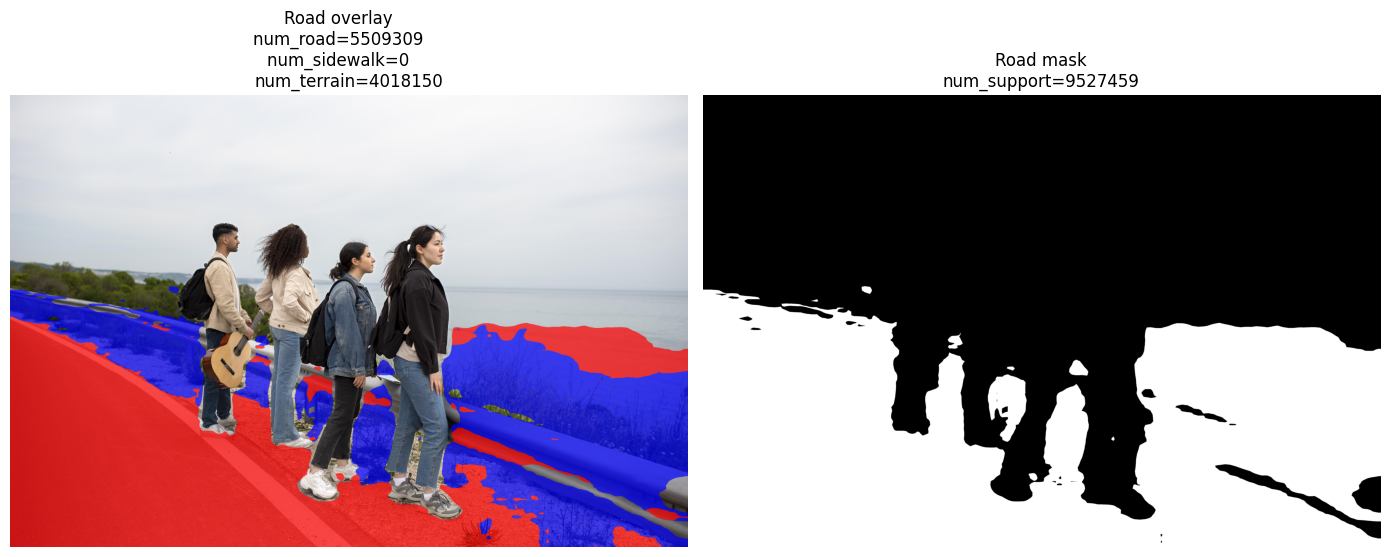

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
ax[0].set_title(
    f"Road overlay\
    \nnum_road={info['num_road']}\
    \nnum_sidewalk={info['num_sidewalk']}\
    \nnum_terrain={info['num_terrain']}")
ax[0].axis("off")

ax[1].imshow(support_masks["support"], cmap="gray")
ax[1].set_title(f"Road mask\nnum_support={info['num_support']}")
ax[1].axis("off")

plt.tight_layout()
plt.show()

In [13]:
from pathlib import Path
import random

ROOT = Path("data/leftImg8bit_trainvaltest")
IMG_DIR = ROOT / "leftImg8bit" / "val"  

all_imgs = list(IMG_DIR.rglob("*_leftImg8bit.png"))
print("num images found:", len(all_imgs))

N = 6
# random.seed(0)
sample_imgs = random.sample(all_imgs, k=min(N, len(all_imgs)))
for p in sample_imgs:
    print(p)

num images found: 500
data\leftImg8bit_trainvaltest\leftImg8bit\val\frankfurt\frankfurt_000001_055538_leftImg8bit.png
data\leftImg8bit_trainvaltest\leftImg8bit\val\munster\munster_000165_000019_leftImg8bit.png
data\leftImg8bit_trainvaltest\leftImg8bit\val\munster\munster_000027_000019_leftImg8bit.png
data\leftImg8bit_trainvaltest\leftImg8bit\val\frankfurt\frankfurt_000001_007622_leftImg8bit.png
data\leftImg8bit_trainvaltest\leftImg8bit\val\frankfurt\frankfurt_000001_019698_leftImg8bit.png
data\leftImg8bit_trainvaltest\leftImg8bit\val\frankfurt\frankfurt_000001_051516_leftImg8bit.png


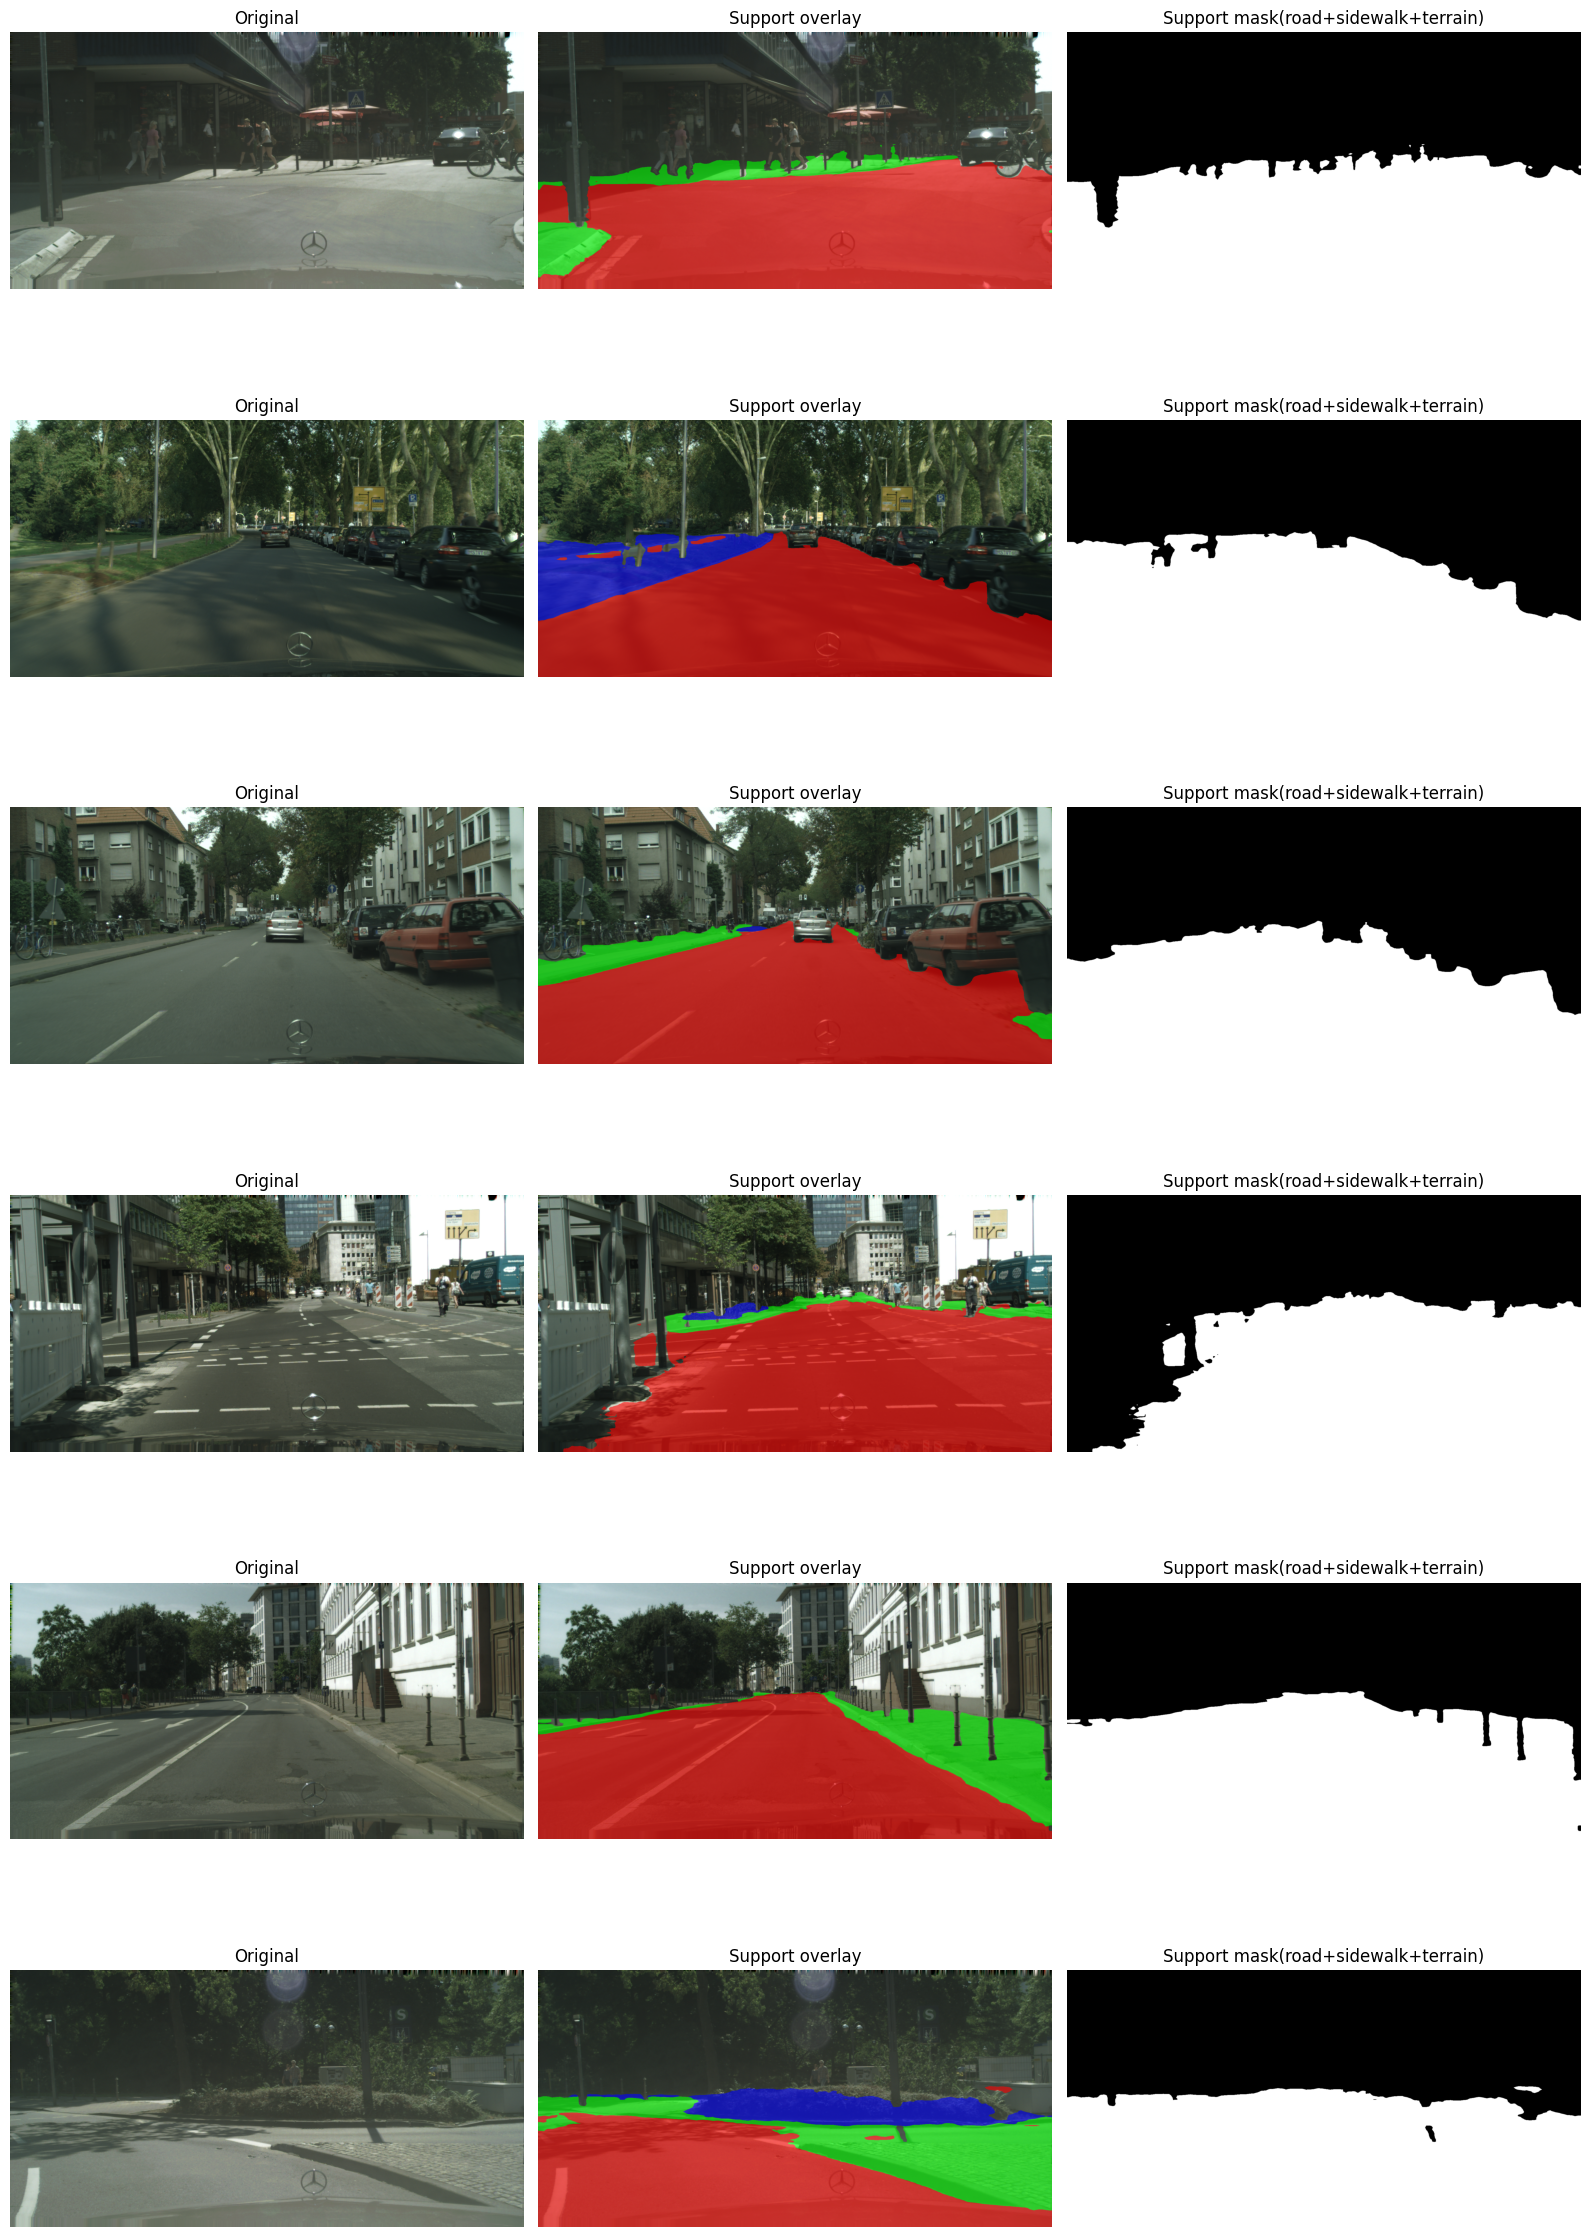

In [14]:
rows = len(sample_imgs)
fig, axes = plt.subplots(rows, 3, figsize=(16, 4 * rows))

if rows == 1:
    axes = np.array([axes])

for i, p in enumerate(sample_imgs):
    img_path = str(p)

    img_pil = Image.open(img_path).convert("RGB")

    support_masks, overlay_bgr, info = segment_support_mask(
        img_path, processor, model, device=device, alpha=0.6
    )

    axes[i, 0].imshow(img_pil)
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title("Support overlay")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(support_masks["support"], cmap="gray")
    axes[i, 2].set_title(f"Support mask(road+sidewalk+terrain)")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()